In [101]:
%%file chemkin_CS207_G9/plotting/RSGraph.py

import random
import graphviz 
from graphviz import Digraph

class RSGraph():
    """
    THIS IS A BASE CLASS
    
    RSGraph is basically the parent class of two types of network graph: BipartiteRSGraph and HierarchicalRSGraph, which are to generate a graph to visualize one or multiple reactions.
    The base class RSGraph builds some basic settings of the graph plot.
    
    ATTRIBUTES
    ===========
    rs: ReactionSystem object, pass in the reaction system to be built graph
    top: graphviz Digraph, dot graph to be plotted graph
    default_style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge", default setting of graph
    
    INITIALIZATION
    ===============
    __init__(self, reaction_sys, format="pdf",style=None)
    
    
    INPUTS: 
    ---------------
        reaction_sys: ReactionSystem object, reaction system to build network graph
        format: Optional string, graph format to be expected to show, initilizaed to be "pdf"
        style: Optional, a dictionary with 3 sub-dictionaries of "graph", "node", "edge", initialized to default_style as follows.
    
    METHODS
    =======
    modify_current_style(self, style):
        modify the current style of graph
        Inputs: 
            style: a dictionary with 3 sub-dictionaries of "graph", "node", "edge", initialized to default_style as follows.
    
    reset_default_style(self):
        reset the style (self.current_style) to be default (self.default_style)
    
    plot(self,method='jupyter',path=""):
        Displays current top graph in jupyter or pdf version. If pdf selected, also saves the image. 
        If no path has been specified, the image is saved in the current directory.
        Inputs:
            method: optional string, "jupyter" or "pdf", default to be "jupyter"
            path: optional string, saved path, default to be the current directory.
        
    
    EXAMPLE
    ========
    rs = ReactionSystem(reactions)
    graph = RSGraph(rs)
    graph.plot()   # Displays a graph with customized setting on a jupyter notebook without saving to pdf
    
    """
    
    def __init__(self, reaction_sys, format="pdf",style=None):
        self.rs = reaction_sys
        
        self.default_style = {
            'graph': {
                'fontsize': '16',
                'fontcolor': 'white',
                'bgcolor': '#333333',
                'rankdir': 'BT',
                'pad':'1'
            },
            'nodes': {
                'fontname': 'Helvetica',
                'shape': 'octagon',
                'fontcolor': 'white',
                'color': 'white',
                'style': 'filled',
                'fillcolor': 'black',
            },
            'edges': {
                'style': 'dashed',
                'color': 'white',
                'arrowhead': 'open',
                'fontname': 'Courier',
                'fontsize': '12',
                'fontcolor': 'white',
            }
        }
        
        self.current_style = self.default_style
        self.initialize_top_graph(format,style)
    
    
    def initialize_top_graph(self, format="pdf", style = None):
        self.top = Digraph(format = format)
        self.apply_style(self.current_style)
    
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        raise NotImplementedError
        
        
    def apply_style(self, style):
        """
        Changes the style of the top graph. Input style should be a dictionary with 3 sub-dictionaries:
        one for graph, one for nodes and one for edges.
        """
        self.top.graph_attr.update(('graph' in style and style['graph']) or {})
        self.top.node_attr.update(('nodes' in style and style['nodes']) or {})
        self.top.edge_attr.update(('edges' in style and style['edges']) or {})
       
    
    def get_random_color(self):
        """
        Generates a random hexadecimal color.
        """
        return '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
         
    def reset_default_style(self):
        self.modify_current_style(self.default_style)
      
    def modify_current_style(self, style):
        self.current_style = style
    
    def plot(self,method='jupyter',path=""):
        if method == 'jupyter':
            return self.top
        
        elif method == 'pdf':
            self.top.view()
        
        else:
            raise ValueError('Unknown method. Valid methods are "jupyter" or "pdf".')
    
    
    def plot_reactions(self, method = 'jupyter', path = "", idxs = []):
        raise NotImplementedError
        
    def plot_system(self,method='pdf',path=""):
        raise NotImplementedError
        
    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
        raise NotImplementedError
        
    def set_edges(self, reaction, color):
        raise NotImplementedError
        
    def save_mp4(self,imgs, path):
        raise NotImplementedError

        
class BipartiteRSGraph(RSGraph):
    """
    This class generates a graph to visualize the whole reaction system. 
    It builds nodes for both species and id of equation and seperate them into two parts.
    We construct a bipartite graph with species as nodes (u,1) in one side, and reactions as nodes (u,2) in another side. 
    Build directed edges (u,1) to (v,2) if edge u is the reactant of equation v. 
    Build directed edges (u,2) to (v,1) if edge v is the product of equation u. 
    Set edges to be dashed if the equation is reversible, otherwise filled.
    From this graph, we could recompute the reaction equations.
    The graph assigns a color to each equation (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted with different grouping options and style options.
    
    METHODS
    =======
    plot_system(self, method='jupyter', path=""):
        plot the bipartite graph for the whole reaction system with optional parameters method and path passed to plot function.
        Inputs:
            method: optional string, "jupyter" or "pdf", default to be "jupyter"
            path: optional string, saved path, default to be the current directory.

    EXAMPLES
    ========
    rs = ReactionSystem(reactions)
    b_graph = BipartiteRSGraph(rs)
    b_graph.plot_system(method='jupyter') 

    
    """
    
    def plot_system(self, method='jupyter', path=""):
        self.initialize_top_graph()
        
        self.top.graph_attr.update(rankdir='LR')
        
        self.top.graph_attr.update(ranksep='2')
        
        with self.top.subgraph(name='cluster_1') as c:
#             c.attr(label='Reaction', labelloc = 'b')
            c.attr(label='Reaction')
            c.attr(color='white')
            for idx in range(len(self.rs.get_reactions())):
                c.node(str(idx))

        with self.top.subgraph(name='cluster_0') as c:
            c.attr(color='white')
            c.attr(label='Species')
            for s in self.rs.get_species():
                c.node(s)
        
        for idx, r in enumerate(self.rs.get_reactions()):
            c = self.get_random_color()
            if r.is_reversible():
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c)
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c)
            else:
                for k1 in r.getReactants():
                    self.top.edge(k1, str(idx), color = c, style = "filled")
                for k2 in r.getProducts():
                    self.top.edge(str(idx), k2, color = c, style = "filled")
        
        return self.plot(method=method, path=path)    
    
    
class HierarchicalRSGraph(RSGraph):
    """
    This class generates a graph to visualize one or multiple reactions. The graph assigns a color to each equation 
    (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted all at once or separately, with different grouping options and style options.
    
    METHODS
    =======
    plot_reactions(self, method = 'jupyter', path = "RSGraph", idxs = []):
        Plots individual graphs for each reaction in the ReactionSystem. The variable idxs allows the user
        to select specific reactions from the RS system to plot.
        Input:
            method: optional string, "jupyter" or "pdf", default to be "jupyter"
            path: optional string, saved path, default to be the current directory.
            idxs: optional list of int, default to plot all the equations
    
    plot_system(self,method='jupyter',path="RSGraph"):
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        In the full reaction system. If the amount of reactions in the system is less than 4, the plot will be generated
        With 2 columns of species, representing on the left the species that are more reactant than product, and on the right
        the species that are more product than reactant. If the system has more than 4 reactions, an automatic organization
        of nodes is performed instead.
        
    
    EXAMPLES
    ========
    rs = ReactionSystem(reactions)
    h_graph = HierarchicalRSGraph(rs)
    h_graph.view(method='jupyter')
    
    """
    
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        """
        Builds a hierarchical graph for one reaction.
        """
        
        if color == None:
            color =self.get_random_color()
            
        r_graph = Digraph(prefix+'Reaction')
        r_graph.graph_attr.update(label = reaction.get_reaction_equation())
        
        for s in reaction.getReactants().keys():
            r_graph.node(reaction.get_reaction_equation()+' --- '+s, label = s, rank = 'min')
        for s in reaction.getProducts().keys():
            r_graph.node(reaction.get_reaction_equation()+' --- '+s, label = s, rank = 'max')
        
        
        r_graph = self.set_edges(r_graph, reaction, color, node_prefix=reaction.get_reaction_equation()+' --- ')
            
        return r_graph
    
    def plot_reactions(self, method = 'jupyter', path = "RSGraph", idxs = []):
        """
        Plots individual graphs for each reaction in the ReactionSystem. The variable idxs allows the user
        to select specific reactions from the RS system to plot.
        """
        
        self.initialize_top_graph()
        
        if not idxs:
            idxs = list(range(len(self.rs.get_reactions())))
            
        r_graph = []
        for i,r in enumerate([self.rs.get_reactions()[i] for i in idxs]):
            r_graph.append( self.build_reaction_graph(r, prefix = 'cluster'+str(i)) )
            self.top.subgraph(r_graph[i])
        
        return self.plot(method = method, path=path)
        
    
    def plot_system(self,method='jupyter',path="RSGraph"):
        self.initialize_top_graph()
        self.top.graph_attr.update(rankdir='LR')
        
        if len(self.rs.get_reactions()) <=4:
            self.top.graph_attr.update(ranksep='2')
            reac = Digraph('Reactant graph')
            prod = Digraph('Product graph')
            reac.graph_attr.update(rank = 'source')
            prod.graph_attr.update(rank = 'sink')
            reactant_count = {}
            product_count = {}
            for s in self.rs.get_species():
                reactant_count[s]=0
                product_count[s]=0
                for r in self.rs.get_reactions():
                    if s in r.getReactants().keys():
                        reactant_count[s]+=1
                    if s in r.getProducts().keys():
                        product_count[s]+=1
            for s in self.rs.get_species():
                if reactant_count[s] >= product_count[s]:
                    reac.node(s)
                elif reactant_count[s] < product_count[s]:
                    prod.node(s)
            self.top.subgraph(reac)
            self.top.subgraph(prod)
            
        else:
            for s in self.rs.get_species():
                self.top.node(s)
        for reaction in self.rs.get_reactions():
            color = self.get_random_color()
            self.top = self.set_edges(self.top, reaction, color)
    
        return self.plot(method=method, path=path)
    
    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
        
        for n in range(timesteps):
            self.rs.concentration_step()
            imgs.append(self.plot_system())
        
        self.save_gif(imgs)
    
    def set_edges(self, g, reaction, color, node_prefix = ""):
        """
        build edges for the functions plot_system and build_reaction_graph
        """
        for idx, s1 in enumerate(reaction.getReactants().keys()):
            for s2 in reaction.getProducts().keys():
                if reaction.is_reversible():
                    g.edge(node_prefix+s1, node_prefix+s2, arrowhead = 'none', color = color)
                else:
                    g.edge(node_prefix+s1, node_prefix+s2, color = color)
            for jdx, s2 in enumerate(reaction.getReactants().keys()):
                if s1 != s2 and jdx > idx:
                    g.edge(node_prefix+s1, node_prefix+s2, arrowhead = 'none', color = color, style = 'filled') 
        return g 
                    
    def save_mp4(self,imgs, path):
        frames = [ImageClip(img).set_duration(0.1) for img in imgs]
        movie = concatenate_videoclips(frames, method="compose")
        movie.write_videofile(path+".mp4", fps=30)


Overwriting chemkin_CS207_G9/plotting/RSGraph.py


In [91]:
dot_h.plot_reactions(method="pdf")

In [82]:
dot_h = HierarchicalRSGraph(rs2)

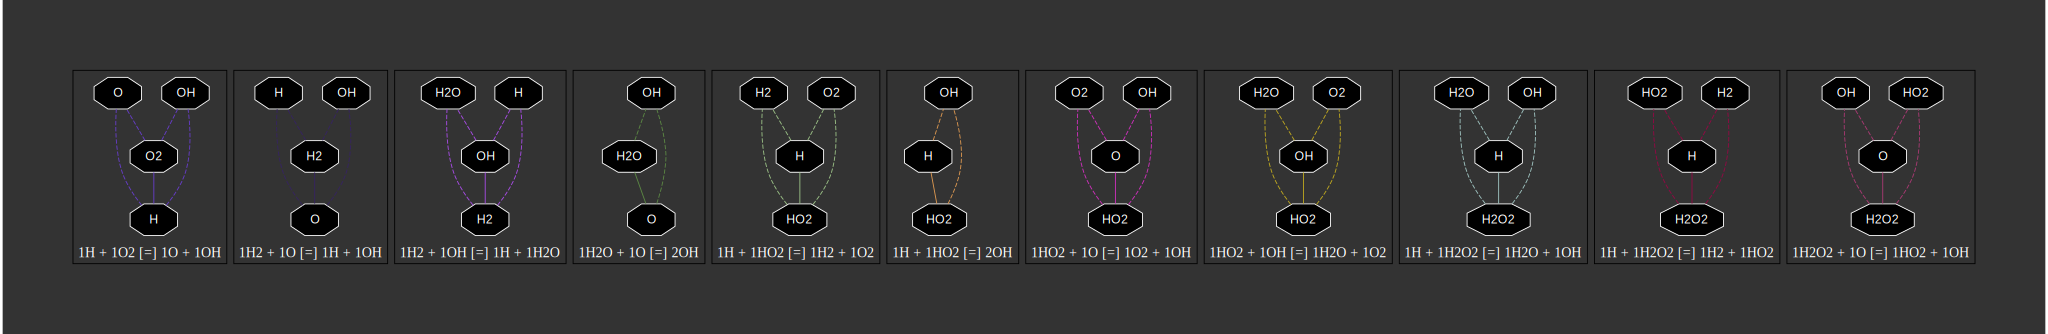

In [100]:
dot_h.plot_reactions()

In [21]:
dot_b = BipartiteRSGraph(rs2)

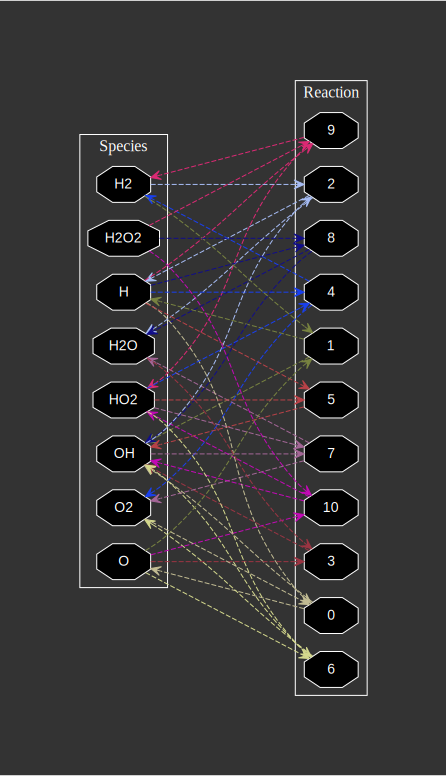

In [22]:
dot_b.plot_system(method = "jupyter")

In [102]:
%%file test/test_RSGraph.py

# Testing
from chemkin_CS207_G9.parser.xml2dict import xml2dict
from chemkin_CS207_G9.parser.database_query import CoeffQuery
from chemkin_CS207_G9.reaction.CoeffLaw import BackwardLaw
from chemkin_CS207_G9.reaction.Reaction import Reaction
from chemkin_CS207_G9.reaction.ReactionSystem import ReactionSystem
import numpy as np
import sys
import os

import numpy as np
from chemkin_CS207_G9.plotting.RSGraph import *
import graphviz
from graphviz import Digraph

# Paths
BASE_DIR = os.path.dirname(os.path.abspath(__file__))
path_xml = os.path.join(BASE_DIR, 'rxns_reversible.xml') # path to the .xml file
path_sql = os.path.join(BASE_DIR, 'nasa_thermo.sqlite')  # path to the .sqlite file

# Loading Reactions and Species from xml file
reader = xml2dict()
reader.parse(path_xml)
info = reader.get_info()
species = info[0]
reactions = [Reaction(**r) for r in info[1]]
cq = CoeffQuery(path_sql)
rs1 = ReactionSystem(reactions[:4], nasa_query = cq)
rs2 = ReactionSystem(reactions, species_ls = species, nasa_query = cq)


def test_RSGraph():
    graph = RSGraph(rs2)
    graph.plot()

def test_BipartiteGraph():
    b_graph = BipartiteRSGraph(rs2)
    b_graph.plot_system(method='jupyter')
    
def test_HierarchicalGraph():
    h_graph = HierarchicalRSGraph(rs2)
    h_graph.plot_system(method='jupyter')

def test_plot_system_on_notebook():
    b_graph = BipartiteRSGraph(rs2)
    b_graph.plot_system(method = 'jupyter')

def test_plot_system_pdf():
    h_graph = BipartiteRSGraph(rs2)
    h_graph.plot_system(method = 'pdf')

def test_plot_reactions_notebook():
    h_graph = HierarchicalRSGraph(rs1)
    g=h_graph.plot_reactions(method = 'jupyter')
    assert(type(g) == Digraph)
    return g    
    
def test_wrong_plot_method():
    graph = RSGraph(rs2)
    try:
        graph.plot(method = 'wrong_format')
    except Exception as err:
        assert(type(err) == ValueError)
        
def test_plot_system_more_than_4_reactions():
    h_graph = HierarchicalRSGraph(rs2)
    g= h_graph.plot_system(method = 'jupyter')
    assert(type(g) == Digraph)
    return g

def test_plot_only_2_reactions():
    h_graph = HierarchicalRSGraph(rs1)
    g=h_graph.plot_reactions(method = 'jupyter', idxs = [2,1])
    assert(type(g) == Digraph)
    return g

def test_plot_single_reaction():
    h_graph = HierarchicalRSGraph(rs1)
    g= h_graph.plot_reactions(method = 'jupyter', idxs = [1])
    assert(type(g)==Digraph)
    return g    

def test_plot_reaction_idx_out_of_range():
    h_graph = HierarchicalRSGraph(rs1)
    try:
        h_graph.plot_reactions(method = 'jupyter', idxs = [7])
    except Exception as err:
        assert(type(err)==IndexError)
    
def test_changing_styles():
    b_graph = BipartiteRSGraph(rs1)
    new_style = {
        'graph': {
            'fontsize': '16',
            'fontcolor': 'white',
            'bgcolor': '#333333',
            'rankdir': 'BT',
            'pad':'1'
        },
        'nodes': {
            'fontname': 'Courier',
            'shape': 'circle',
            'fontcolor': 'white',
            'color': 'white',
            'style': 'dashed',
            'fillcolor': 'black',
        },
        'edges': {
            'style': 'bold',
            'color': 'white',
            'arrowhead': 'empty',
            'fontname': 'Courier',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }
    
    b_graph.modify_current_style(new_style)
    g = b_graph.plot_system()
    assert(type(g)==Digraph)
    g



Overwriting test/test_RSGraph.py


In [103]:
!pytest --doctest-modules --cov --cov-report term-missing

============================= test session starts ==============================
platform darwin -- Python 3.6.1, pytest-3.0.7, py-1.4.33, pluggy-0.4.0
rootdir: /Users/gwungwun/cs207-FinalProject, inifile: setup.cfg
plugins: cov-2.5.1
collected 60 items 

chemkin_CS207_G9/auxiliary/check_and_response.py .
chemkin_CS207_G9/auxiliary/mathematical_science.py .
chemkin_CS207_G9/reaction/CoeffLaw.py ...
chemkin_CS207_G9/reaction/Reaction.py ..
test/test_CoeffLaw.py ....
test/test_NonNetworkPlot.py ...
test/test_RSGraph.py ............
test/test_Reaction.py ........
test/test_ReactionSystem.py .................
test/test_database_query.py ...
test/test_xml2dict.py ......

---------- coverage: platform darwin, python 3.6.1-final-0 -----------
Name                                                                      Stmts   Miss  Cover   Missing
-------------------------------------------------------------------------------------------------------
/Users/gwungwun/.local/lib/python3.6/site-pack